In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [2]:
content_layer_num = 1
image_size = 256
epoch = 5000

In [3]:
content_dir = "./image/content/kyoto_sub_01.jpg"
style_dir = "./image/style/hokusai.jpg"

In [4]:
def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Scale(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                         std=[1,1,1]),
                ])
    img = transform(img).view((-1,3,image_size,image_size))
    return img

In [5]:
# add imagenet mean to normalize the output image
# bound the image -1 to 1

def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                     std=[1,1,1])
    img = transform(tensor.clone())
    img = img.clamp(0,1)

    return img

In [6]:
def imshow(tensor):
    image = tensor.clone().cpu()
    image = image.view(3, image_size, image_size)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    plt.show()

In [7]:
resnet = models.resnet50(pretrained=True)
for name,module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [8]:
# return activations in each layers 

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)

        return out_0, out_1, out_2, out_3, out_4, out_5

In [9]:
# gram matrix
# [batch,channel,height,width] -> [b,c,h*w]
# [b,c,h*w] x [b,h*w,c] = [b,c,c]

class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        return G

In [10]:
# return activations in each layers 

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet,self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self,x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)

        return out_0, out_1, out_2, out_3, out_4, out_5

In [11]:
# model is not updated so .requires_grad = False

resnet = Resnet().cuda()
for param in resnet.parameters():
    param.requires_grad = False

In [12]:
# gram matrix mean squared error

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return out

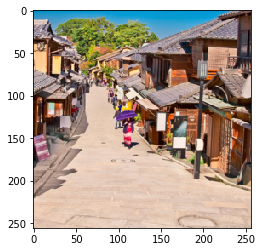

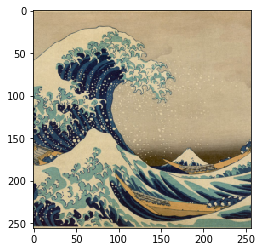

In [13]:
# get content and style image & image to be generated

content = Variable(image_preprocess(content_dir), requires_grad=False).cuda()
style = Variable(image_preprocess(style_dir), requires_grad=False).cuda()
generated = Variable(content.data.clone(),requires_grad=True)

# show content image, style image and generated image

imshow(image_postprocess(image_preprocess(content_dir)))
imshow(image_postprocess(image_preprocess(style_dir)))

In [14]:
# set targets and style weights

style_target = list(GramMatrix().cuda()(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

In [15]:
# set LBFGS optimizer
# change the image through training
# for more info about LBFGS -> http://pytorch.org/docs/optim.html?highlight=lbfgs#torch.optim.LBFGS

optimizer = optim.LBFGS([generated])

iteration = [0]
while iteration[0] < epoch:

    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        style_loss = [GramMSELoss().cuda()(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]
        content_loss = nn.MSELoss().cuda()(out[content_layer_num],content_target)
        total_loss = 1000 * sum(style_loss) + sum(content_loss)
        total_loss.backward()

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1

        return total_loss

    optimizer.step(closure)

Variable containing:
1.00000e+05 *
  1.5601
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 3.1066
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.6988
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.3775
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2580
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.2032
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1707
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1504
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1358
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1253
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1174
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1113
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1063
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0.1021
[torch.

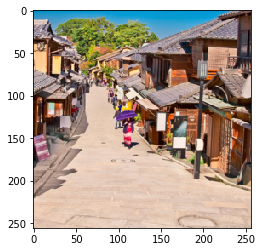

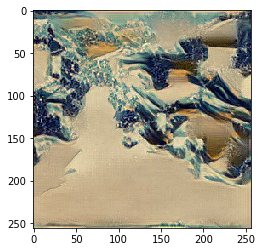

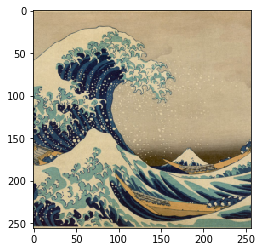

In [16]:
# content image, generated image, style image

imshow(image_postprocess(image_preprocess(content_dir)))
imshow(image_postprocess(generated.data))
imshow(image_postprocess(image_preprocess(style_dir)))

In [17]:
v_utils.save_image(image_postprocess(generated.data),"./result/kyoto_with_hokusai.png")
v_utils.save_image(generated.data,"./result/kyoto_with_hokusai02.png")